### ANOVA tests
https://towardsdatascience.com/anova-test-with-python-cfbf4013328b

One-Way ANOVA
It is a test where a particular factor has more than 2 groups or levels of interest. For example, let μ be the true mean annual salary of graduates
Single-factor of interest = Study subjects
Assume we have 6 categories of study subjects, Factor levels = athematics and Statistics, Economics and Finance, Environmental Sciences, Political Science, Social Sciences and Biology.
Hence, there are 6 levels or groups of this single factor in affecting the mean of the annual salary of graduates.
The basic idea behind a one-way ANOVA is to take independent random samples from each group, then compute the sample means for each group. After that compare the variation of sample means among the groups to the variation within the groups. Finally, make a decision based on a test statistic, whether the means of the groups are all equal or not.
Sum of Squares (SS)
Inside the One-Way ANOVA Table:
The total amount of variability comes from two possible sources, namely:
1. Difference among the groups, called treatment (TR)
2. Difference within the groups, called error (E)
The sum of the squares due to treatment (SSTR) and the sum of squares due to error (SSE) are listed in the one-way ANOVA table. The sum of SSTR and SSE is equal to the total sum of squares (SSTO).

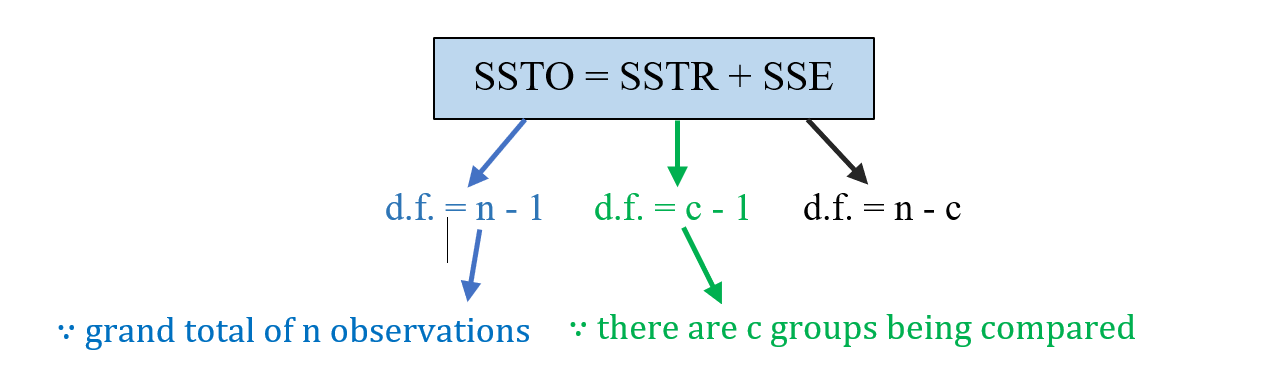

Just like for SS, d.f. (SSTO) = d.f. (SSTR) + d.f. (SSE)
Mean Squares (MS)
A mean square is the sum of squares divided by its d.f. These mean squares are all variances and will be used in the hypothesis test of the equality of all the group population means.
Assumptions for the one-way ANOVA hypothesis test
Sample data are randomly selected from populations and randomly assigned to each of the treatment groups. Each observation is thus independent of any other observation — randomness and independence.
Normality. Values in each sampled groups are assumed to be drawn from normally distributed populations. We can use normal probability plot or Q-Q plot to check normality.
Homogeneity of variance. All the c group variances are equal, that is σ₁² = σ₂² = σ₃² = … = σ𝒸². As a rule of thumb, if the ratio of the largest to the smallest sample standard deviation is less than 2, we consider the equal standard deviations assumption as fulfilled.
The simple outline of the one-way ANOVA test:
F test for differences in more than two means
H₀: μ₁= μ₂ = μ₃ = … = μ𝒸
H₁: Not all μᵢ’s are equal, where i = 1, 2, 3, …, c.
Level of significance = α

Finally, the one-way ANOVA table is as shown below:

In [1]:
import pandas as pd
import random

# read original dataset
student_df = pd.read_csv('students.csv')

# filter the students who are graduated
graduated_student_df = student_df[student_df['graduated'] == 1]

# random sample for 500 students 
unique_student_id = list(graduated_student_df['stud.id'].unique())
random.seed(30) # set a seed so that everytime we will extract same sample
sample_student_id = random.sample(unique_student_id, 500)
sample_df = graduated_student_df[graduated_student_df['stud.id'].isin(sample_student_id)].reset_index(drop=True)

# two variables of interest
sample_df = sample_df[['major', 'salary']]
groups = sample_df.groupby('major').count().reset_index()
# groups.plot(kind='bar',x='major',y='salary')
groups

,major,salary
0,Biology,87
1,Economics and Finance,94
2,Environmental Sciences,97
3,Mathematics and Statistics,75
4,Political Science,84
5,Social Sciences,63


### Normality assumption check using Q_Q plots

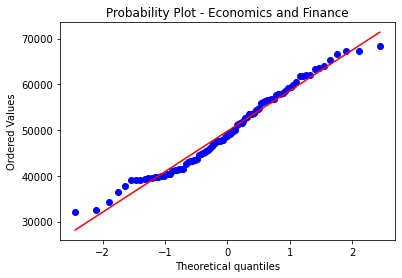

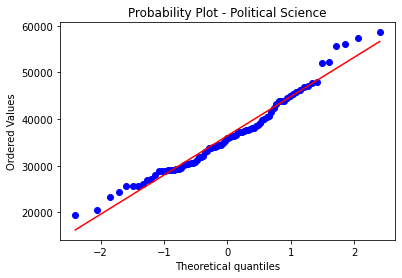

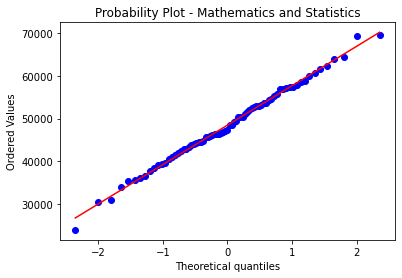

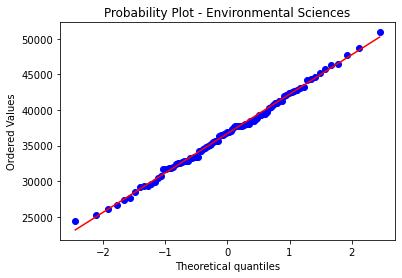

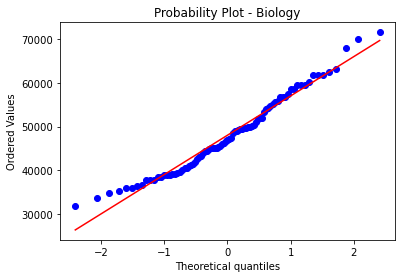

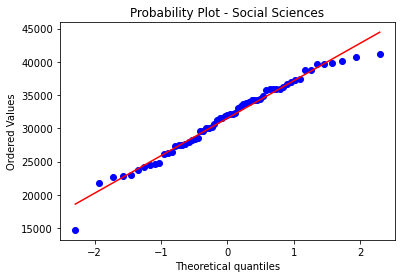

In [2]:
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt

unique_majors = sample_df['major'].unique()
for major in unique_majors:
    stats.probplot(sample_df[sample_df['major'] == major]['salary'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  major)
    plt.show()

### Homogeneity of variance Assumption Check


In [3]:
# calculate ratio of the largest to the smallest sample standard deviation
ratio = sample_df.groupby('major').std().max() / sample_df.groupby('major').std().min()
ratio

salary    1.669921
dtype: float64

Hypothesis Testing

According to five steps process of hypothesis testing:

H₀: μ₁= μ₂ = μ₃ = … = μ₆

H₁: Not all salary means are equal

α = 0.05

According to F test statistics:

In [4]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = sample_df['salary'].mean()
SSTR = sample_df.groupby('major').count() * (sample_df.groupby('major').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['salary'].sum()

# calculate SSE and update anova table
SSE = (sample_df.groupby('major').count() - 1) * sample_df.groupby('major').std()**2
anova_table['SS']['Within Groups'] = SSE['salary'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['salary'].sum() + SSE['salary'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = sample_df['major'].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df['major'].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,24184075535.074078,5,4836815107.014815,77.408037,0.0,2.592178
Within Groups,30867423591.219269,494,62484663.14012,,,
Total,55051499126.29335,499,110323645.543674,,,


In [5]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and critical value is:", anova_table['F crit']['Between Groups'])
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 77.40803685167356  and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
F-score is: 77.40803685167356  and critical value is: 2.592178494905
Null Hypothesis is rejected.


### Conclusion: We have enough evidence that not all average salaries are the same for graduates of different study subjects, at 5% significance level.

# One sample hypothesis tests
https://levelup.gitconnected.com/how-to-perform-one-sample-hypothesis-tests-with-python-308eae8789fc

A Hypothesis Test is a statistical test that is used to test the assumption or hypothesis made and draw a conclusion about the entire population. In this article, I will share how to run one-sample hypothesis testing on a single population with different scenarios.
The FIVE STEPS begin here:

1. Define the Null Hypothesis (H₀)
The null hypothesis is the starting line of a hypothesis test or initial claim what someone believes he has evidence for.
Always uses parameters such as μ or σ or 𝛑, depending on types of test.
A null hypothesis always contains an equal sign: =, ≤, or ≥.

2. Define the Alternative Hypothesis (H₁)
The opposing statement to H₀ and is a suspicious claim or finding what someone wants to prove.
Always uses parameters such as μ or σ or 𝛑, depending on types of test.
H₁ never has an equal sign in its statement, it takes on strict inequalities: ≠ or < or >.

3. Set the Level of Significance (α)
Is the probability of committing Type I error, where
α = P (Type I error) = P (rejecting H₀ when H₀ is true)
Preset and usually selected as 0.01, 0.05, 0.1.

4. Collect data and calculate the Test Statistic

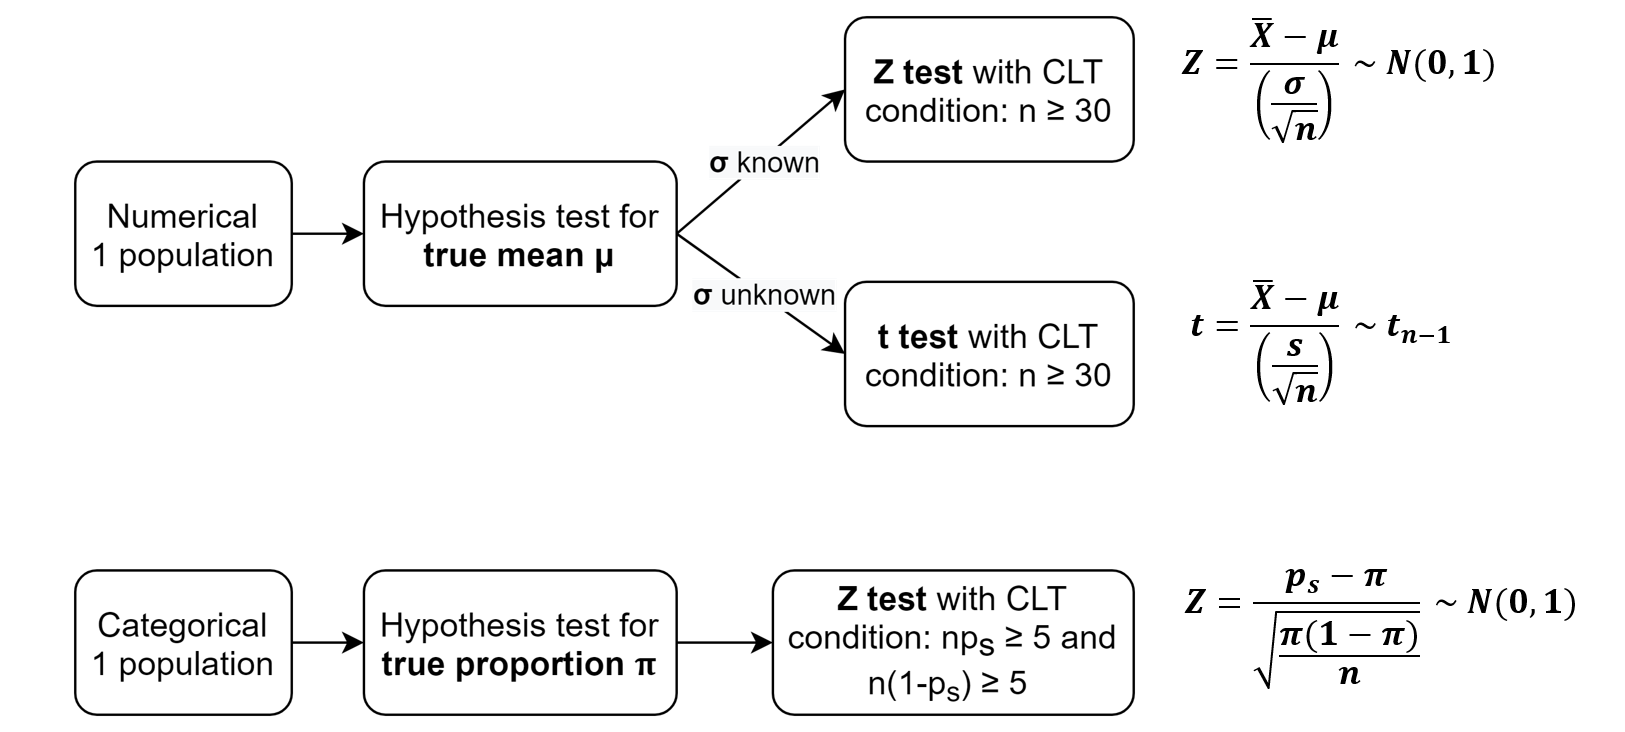

5. Construct the Rejection and Non-Rejection Regions
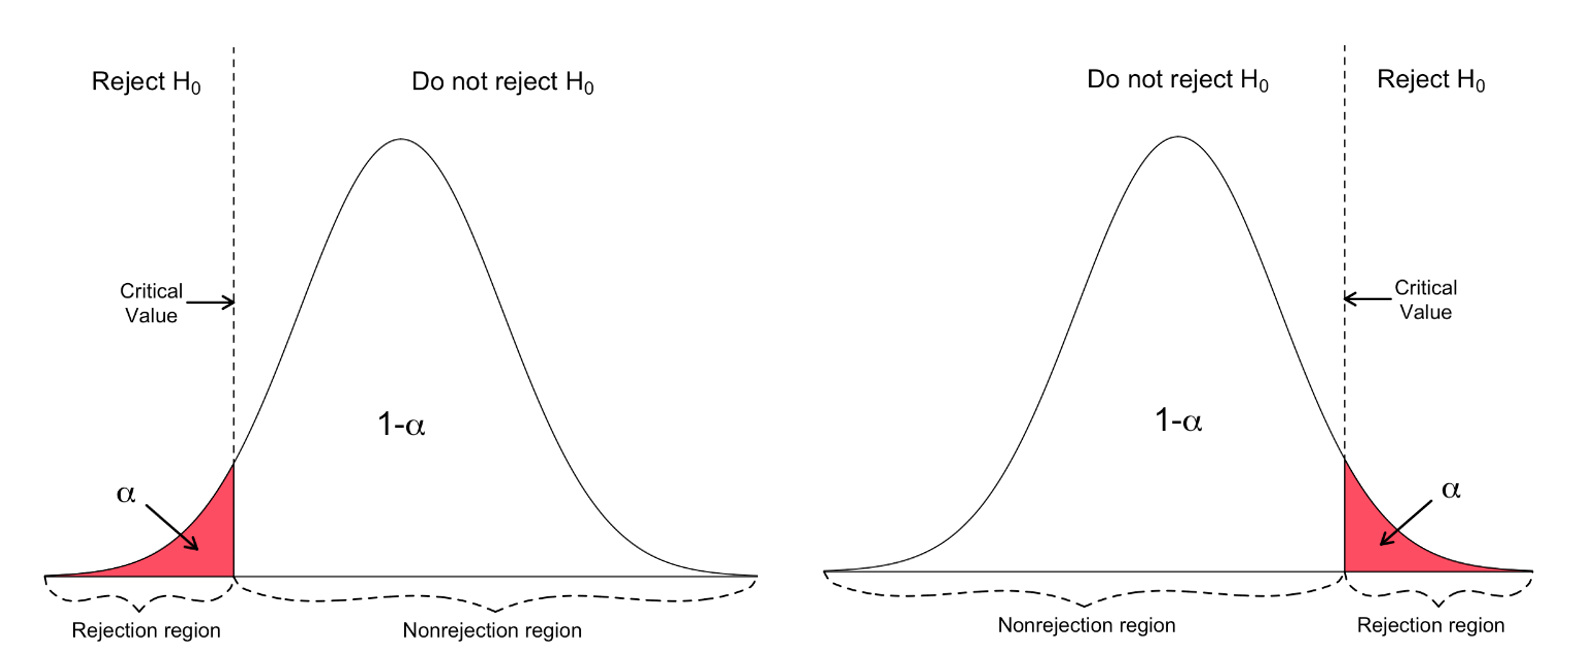
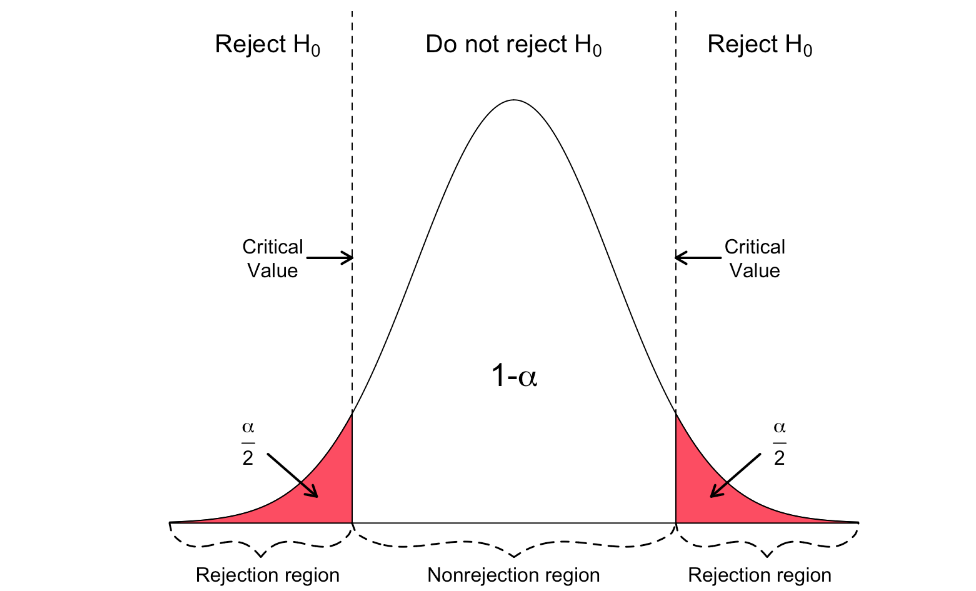

The decision rule or the critical value of a test statistic divides the entire area under the curve (Z curve or t curve) into two main regions: the tiny rejection region and the monstrous non-rejection region.
Finally, based on test statistics and the decision rule, we make the decision to determine whether to reject or not to reject H₀ at α significance level.

Going through TEST STATISTICS with examples:
Example 1: Carl Reinhold August Wunderlich was a doctor who pioneered the measurement of average healthy human body temperature which he found to be 98.6°F. Almost 150 years later, researchers at the University of Maryland evaluate the famous 98.6°F standard. They measured the body temperatures of 148 healthy men and women, who yielded an average of 98.24923°F. With the traditionally known standard deviation of human body temperatures at about 0.63°F, is there evidence at 1% level of significance that the true average human body temperature differs from 98.6°F? [2]
Let μ be the true mean human body temperature in °F
Given: n = 148, x̄ = 98.24923°F, σ = 0.63°F
Now let’s follow the five steps:
1. H₀: μ = 98.6°F
2. H₁: μ ≠ 98.6°F (2 tailed test)
3. α = 0.01
4. Following Figure 1, it is a one-sample two-tailed Z test for true mean μ with known variance σ.


In [6]:
import math
import scipy.stats as stats

x_bar = 98.24923
u = 98.6
sigma = 0.63
n = 148
alpha = 0.01

# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"

if tail_hypothesis_type == "two-tailed":
    alpha /= 2

print("One-Sample", tail_hypothesis_type, "Z-test of true mean")
print("--------------------------------------------------------------------------------------")
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
if n >= 30:
    print("Since sample size >= 30, by CLT ")
    z_score = (x_bar - u)/(sigma/math.sqrt(n))
    if tail_hypothesis_type == "left-tailed":
        p_value = stats.norm.cdf(z_score)
    elif tail_hypothesis_type == "right-tailed":
        p_value = 1 - stats.norm.cdf(z_score) # or stats.norm.sf(z_score)
    else:
        z_score = abs(z_score)
        p_value = 1 - stats.norm.cdf(z_score)
            
    conclusion = "Failed to reject the null hypothesis."
    if p_value <= alpha:
        conclusion = "Null Hypothesis is rejected."
        
    print("z-score is:", z_score, " and p value is:", p_value)
    print(conclusion)
else:
    print("CLT is not satisfied")

# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
if n >= 30:
    print("Since sample size >= 30, by CLT ")
    z_score = (x_bar - u)/(sigma/math.sqrt(n))
    critical_value = stats.norm.ppf(abs(alpha))
    
    conclusion = "Failed to reject the null hypothesis."
    if tail_hypothesis_type == "left-tailed":
        if z_score < critical_value:
            conclusion = "Null Hypothesis is rejected."
    elif tail_hypothesis_type == "right-tailed":
        critical_value = abs(critical_value)
        if z_score > critical_value:
            conclusion = "Null Hypothesis is rejected."
    else:
        z_score = abs(z_score) 
        critical_value = abs(critical_value)
        if z_score > critical_value:
            conclusion = "Null Hypothesis is rejected."

    print("z-score is:", z_score, " and critical value is:", critical_value)
    print(conclusion)
else:
    print("CLT is not satisfied")

One-Sample two-tailed Z-test of true mean
--------------------------------------------------------------------------------------
Approach 1: The p-value approach to hypothesis testing in the decision rule
Since sample size >= 30, by CLT 
z-score is: 6.7734940087386954  and p value is: 6.285416631612861e-12
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
Since sample size >= 30, by CLT 
z-score is: 6.7734940087386954  and critical value is: 2.575829303548901
Null Hypothesis is rejected.


### Conclusion: We have enough evidence that the true mean body temperature is NOT 98.6°F, at 1% significance level.

Example 3: Suppose the CEO claims that at least 80 percent of the company’s 1,000,000 customers are very satisfied. Again, 100 customers are surveyed using simple random sampling. The result stated 73 percent are very satisfied. Based on these results, should we accept or reject the CEO’s hypothesis? Assume a significance level of 0.05. [4]
Let 𝛑 be the true proportion of very satisfied customers
Given: n = 100, pₛ= 0.73
Now let’s follow the five steps:
1. H₀: 𝜋 ≥ 0.8
2. H₁: 𝜋 < 0.8 (left-tailed test)
3. α = 0.05
4. Following Figure 1, it is a one-sample left-tailed Z test for true proportion 𝜋.

In [7]:
import math
import scipy.stats as stats

pi = 0.8
ps = 0.73
n = 100
alpha = 0.05

# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "left-tailed"

if tail_hypothesis_type == "two-tailed":
    alpha /= 2

print("One-Sample", tail_hypothesis_type, "Z-test of true proportion")
print("--------------------------------------------------------------------------------------")
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
if n*ps >= 5 and n*(1-ps) >= 5:
    print("Since n*ps >= 5 and n*(1-ps) >= 5, by CLT ")
    z_score = (ps - pi)/math.sqrt((pi*(1-pi))/n)
    if tail_hypothesis_type == "left-tailed":
        p_value = stats.norm.cdf(z_score)
    elif tail_hypothesis_type == "right-tailed":
        p_value = 1 - stats.norm.cdf(z_score) # or stats.norm.sf(z_score)
    else:
        z_score = abs(z_score)
        p_value = 1 - stats.norm.cdf(z_score)
    
    conclusion = "Failed to reject the null hypothesis."
    if p_value <= alpha:
        conclusion = "Null Hypothesis is rejected."
        
    print("z-score is:", z_score, " and p value is:", p_value)
    print(conclusion)
else:
    print("CLT is not satisfied")

# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
if n*ps >= 5 and n*(1-ps) >= 5:
    print("Since n*ps >= 5 and n*(1-ps) >= 5, by CLT ")
    z_score = (ps - pi)/math.sqrt((pi*(1-pi))/n)
    critical_value = stats.norm.ppf(abs(alpha))
    
    conclusion = "Failed to reject the null hypothesis."
    if tail_hypothesis_type == "left-tailed":
        if z_score < critical_value:
            conclusion = "Null Hypothesis is rejected."
    elif tail_hypothesis_type == "right-tailed":
        critical_value = abs(critical_value)
        if z_score > critical_value:
            conclusion = "Null Hypothesis is rejected."
    else:
        z_score = abs(z_score) 
        critical_value = abs(critical_value)
        if z_score > critical_value:
            conclusion = "Null Hypothesis is rejected."

    print("z-score is:", z_score, " and critical value is:", critical_value)
    print(conclusion)
else:
    print("CLT is not satisfied")

One-Sample left-tailed Z-test of true proportion
--------------------------------------------------------------------------------------
Approach 1: The p-value approach to hypothesis testing in the decision rule
Since n*ps >= 5 and n*(1-ps) >= 5, by CLT 
z-score is: -1.7500000000000016  and p value is: 0.04005915686381696
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
Since n*ps >= 5 and n*(1-ps) >= 5, by CLT 
z-score is: -1.7500000000000016  and critical value is: -1.6448536269514729
Null Hypothesis is rejected.


### Conclusion: We have sufficient evidence that the true proportion of very satisfied customers is smaller than 0.8 percent, at 5% significance level.